In [4]:
from datasets import load_dataset
import pandas as pd
from groq import Groq

/Users/oscar.schafer/Library/Caches/pypoetry/virtualenvs/ffc-dbricks-ht-genai-fgXJucMy-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# import dataset
ds = load_dataset("BI55/MedText")

df = pd.DataFrame(ds['train'])

df.head()

,Prompt,Completion
0,A 50-year-old male presents with a history of ...,This patient's history of recurrent kidney sto...
1,"A 7-year-old boy presents with a fever, headac...","This child's symptoms of a red, bulging tympan..."
2,A 35-year-old woman presents with a persistent...,While the symptoms might initially suggest ast...
3,A 50-year-old male presents with severe abdomi...,The patient's symptoms suggest an incarcerated...
4,A newborn baby presents with eye redness and a...,The infant's symptoms suggest neonatal conjunc...


In [11]:
# completions
n_completions = 0
total_completions = len(df['Completion'])
def extract_pathologies(completions, batch_size=1):
    global n_completions, total_completions
    results = []
    total = len(completions)
    for i in range(0, total, batch_size):
        print(f"Processing completion {n_completions}/{total_completions}", end="\r")
        n_completions += batch_size
        batch = completions[i:i+batch_size]        
        prompt = "Given the following medical case descriptions, extract and return only the main pathology or condition mentioned for each case (one per line, one per case, in order). If the pathology is very unclear, return 'unknown', if the text is unrelated to a pathology description, then return 'unrelated'. DON'T RETURN ANYTHING ELSE BUT THE PATHOLOGIES:\n\n"
        for j, completion in enumerate(batch, 1):
            prompt += f"CASE {j}:\n{completion}\n\n"
        prompt += """
        EXAMPLE INPUT:
        CASE 1: This patient's history of recurrent kidney stones, osteopenia, and high-dose vitamin D supplementation, along with laboratory findings of hypercalcemia and hypercalciuria, suggest the possibility of vitamin D toxicity. Excessive intake of vitamin D can cause increased absorption of calcium from the gut, leading to hypercalcemia and hypercalciuria, which can result in kidney stones and bone loss. Treatment would involve stopping the vitamin D supplementation and potentially providing intravenous fluids and loop diuretics to promote the excretion of calcium.
        CASE 2: A 45-year-old patient presents with vague symptoms including fatigue, mild joint pain, and occasional headaches. Physical examination reveals no significant findings, and initial laboratory tests are within normal ranges. The patient's medical history is unremarkable, and they report no recent travel or exposure to infectious diseases. Despite thorough questioning, no clear pattern or specific triggers for the symptoms can be identified.
        CASE 2: This child's symptoms of a red, bulging tympanic membrane with systemic symptoms such as fever and headache, and the additional symptoms of dizziness and a spinning sensation, raise concern for complications of acute otitis media. The differential diagnosis could include labyrinthitis or possibly even mastoiditis. Urgent evaluation, including further imaging studies such as a CT or MRI scan, may be necessary. This child likely requires admission for intravenous antibiotics and possibly surgical intervention if mastoiditis is confirmed.
        CASE 4: While the symptoms might initially suggest asthma, the lack of response to bronchodilators indicates a different cause. A possible diagnosis in this case might be idiopathic pulmonary fibrosis, a type of lung disease that results in scarring (fibrosis) of the lungs for an unknown reason. High-resolution CT of the chest would be the next step in diagnosis.
        CASE 5: The annual report for XYZ Corporation shows a 15% increase in revenue compared to the previous fiscal year. The company attributes this growth to the successful launch of a new product line and expansion into international markets. The board of directors has approved a 5% dividend increase for shareholders. The report also outlines plans for sustainable practices and corporate social responsibility initiatives for the coming year.

        EXAMPLE OUTPUT:
        vitamin d toxicity
        unknown
        acute otitis media, possible complication of labyrinthitis or mastoiditis
        idiopathic pulmonary fibrosis
        unrelated
        """
        

        client = Groq(api_key="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")
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            model="llama-3.1-70b-versatile",
        )
        
        batch_results = response.choices[0].message.content.strip().split('\n')
        results.extend(batch_results)
    
    return results

# Apply the function to the 'Completion' column in batches
batch_size = 10
df['Extracted_Pathology'] = df['Completion'].groupby(df.index // batch_size).apply(
    lambda group: extract_pathologies(group.tolist(), batch_size=batch_size)
).explode().reset_index(drop=True)

# Display the first few rows of the updated dataframe
print(df[['Completion', 'Extracted_Pathology']].head())

['vitamin D toxicity', 'acute otitis media, possible complication of labyrinthitis or mastoiditis', 'idiopathic pulmonary fibrosis', 'incarcerated hernia with suspected bowel obstruction', 'neonatal conjunctivitis', 'osteoarthritis', 'cerebral malaria', 'stable angina due to coronary artery disease', "lateral medullary syndrome or Wallenberg's syndrome", 'aromatase inhibitor-induced arthralgia']
                                          Completion  \
0  This patient's history of recurrent kidney sto...   
1  This child's symptoms of a red, bulging tympan...   
2  While the symptoms might initially suggest ast...   
3  The patient's symptoms suggest an incarcerated...   
4  The infant's symptoms suggest neonatal conjunc...   

                                 Extracted_Pathology  
0                                 vitamin D toxicity  
1  acute otitis media, possible complication of l...  
2                      idiopathic pulmonary fibrosis  
3  incarcerated hernia with suspected bowel 

In [12]:
# Save the DataFrame to a CSV file
output_filename = "medical_cases_with_pathologies.csv"
df.to_csv(output_filename, index=False)

print(f"DataFrame saved successfully as '{output_filename}'")

DataFrame saved successfully as 'medical_cases_with_pathologies.csv'


In [19]:
import re
import pandas as pd
import numpy as np
from groq import Groq

def refine_pathology(pathology):
    if pathology.lower() in ['unknown', 'unrelated', ''] or pd.isna(pathology):
        return None
    return pathology

def request_pathology(prompt):
    client = Groq(api_key="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")
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Extract the main pathology from this medical case: {prompt}"
            }
        ],
        model="llama-3.1-70b-versatile",
    )
    return response.choices[0].message.content.strip()

def fill_empty_pathologies(df):
    mask = df['Normalized_Pathology'].apply(refine_pathology).isna()
    empty_indices = df[mask].index
    
    for idx in empty_indices:
        prompt = df.loc[idx, 'Prompt']
        new_pathology = request_pathology(prompt)
        df.loc[idx, 'Normalized_Pathology'] = clean_and_normalize(new_pathology)
    
    return df

# Fill in empty, unknown, and unrelated values
df = fill_empty_pathologies(df)


def clean_and_normalize(text):
    if pd.isna(text):
        return 'unknown'
    text = str(text)  # Convert to string to handle float values
    # Remove numbering and unnecessary punctuation
    text = re.sub(r'^\d+\.\s*', '', text)
    text = re.sub(r'[""()]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove common prefixes
    text = re.sub(r'^(case\s*\d*:?\s*|possible\s+|suspected\s+)', '', text)
    
    # Replace empty strings with 'unknown'
    text = text.strip()
    return 'unknown' if text == '' else text

# Check for empty values and replace with 'unknown'
df['Normalized_Pathology'] = df['Normalized_Pathology'].apply(lambda x: 'unknown' if pd.isna(x) or x.strip() == '' else x)

# Read the CSV file
df = pd.read_csv('medical_cases_with_pathologies.csv')

# Clean and normalize the pathologies
df['Normalized_Pathology'] = df['Extracted_Pathology'].apply(clean_and_normalize)
# Save the results to a new CSV file
df.to_csv('medical_cases_with_pathologies.csv', index=False)

Refined pathologies and saved to 'medical_cases_with_refined_pathologies.csv'


Basic Information:
<class 'pandas.core.series.Series'>
RangeIndex: 1412 entries, 0 to 1411
Series name: Normalized_Pathology
Non-Null Count  Dtype 
--------------  ----- 
1412 non-null   object
dtypes: object(1)
memory usage: 11.2+ KB
None


Summary Statistics:
count        1412
unique        878
top       unknown
freq           69
Name: Normalized_Pathology, dtype: object


Number of unique pathologies: 878


Top 15 Most Common Pathologies:
Normalized_Pathology
unknown                            69
unrelated                          50
hypothyroidism                     15
iron deficiency anemia             12
osteoporosis                       10
lactose intolerance                10
pulmonary embolism                  9
alzheimer's disease                 9
hyperthyroidism                     8
acute pancreatitis                  8
heart failure                       8
endometriosis                       8
seasonal affective disorder sad     8
osteoarthritis                      8
m

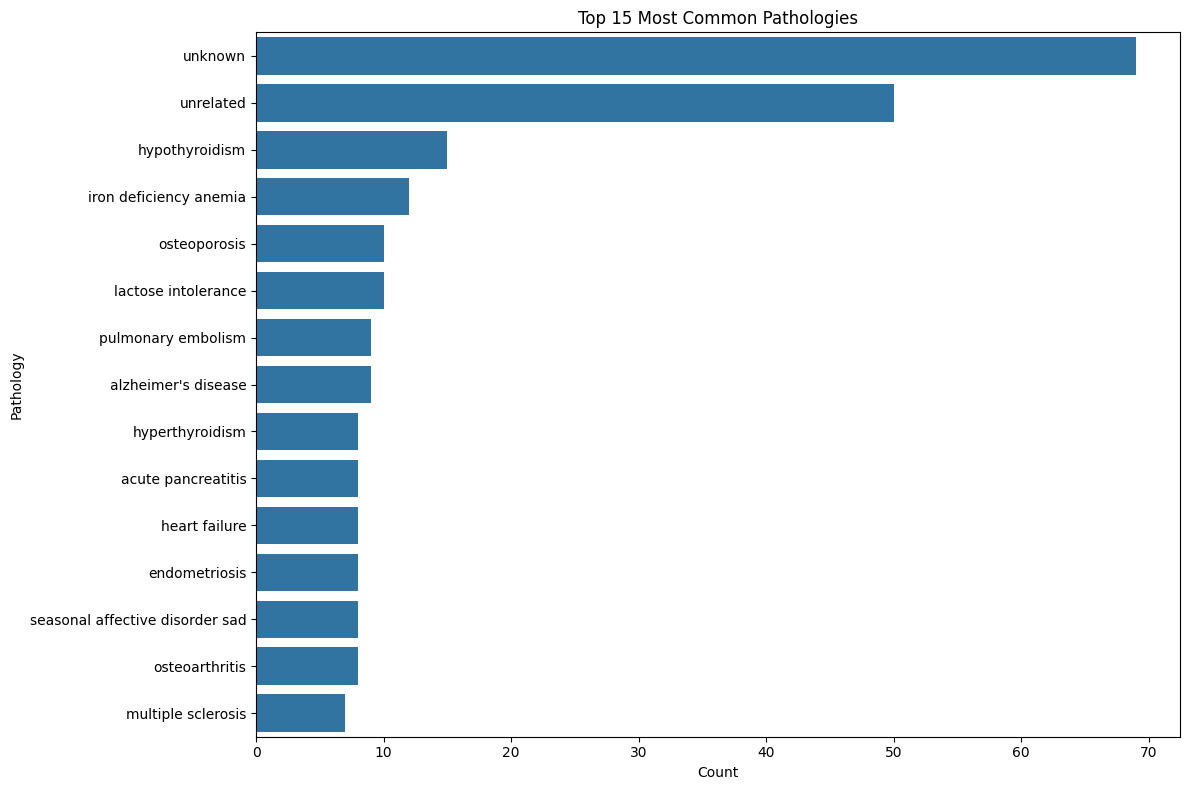

Average length of pathology descriptions: 22.18 characters
Median length of pathology descriptions: 19 characters




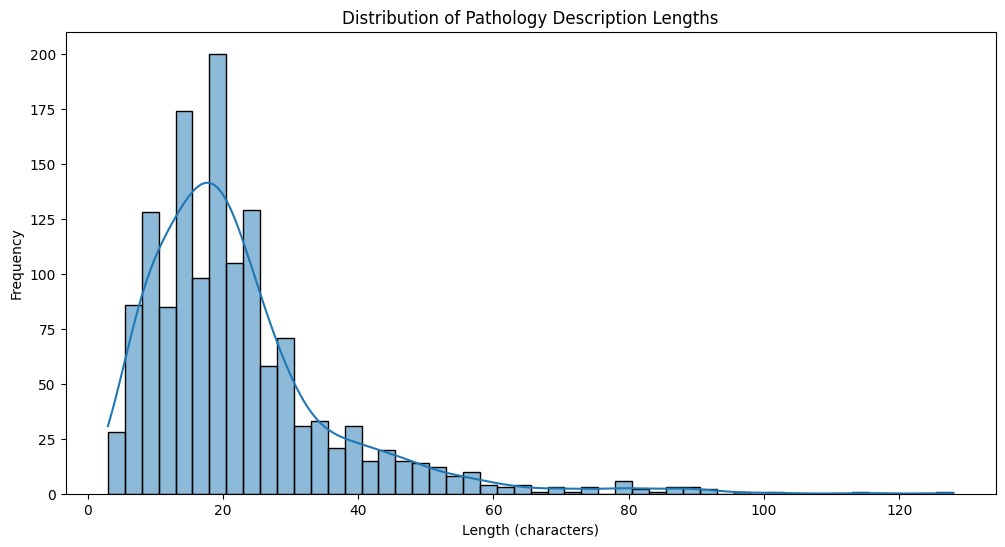

Top 20 Most Common Words:
          Word  Frequency
0           or        105
1      disease        100
2     syndrome         78
3      unknown         70
4     disorder         56
5            s         53
6    unrelated         51
7     fracture         48
8    infection         45
9        acute         39
10        with         36
11     chronic         32
12      anemia         31
13       bowel         27
14          to         27
15      cancer         22
16   pulmonary         21
17      injury         20
18          of         19
19  deficiency         19




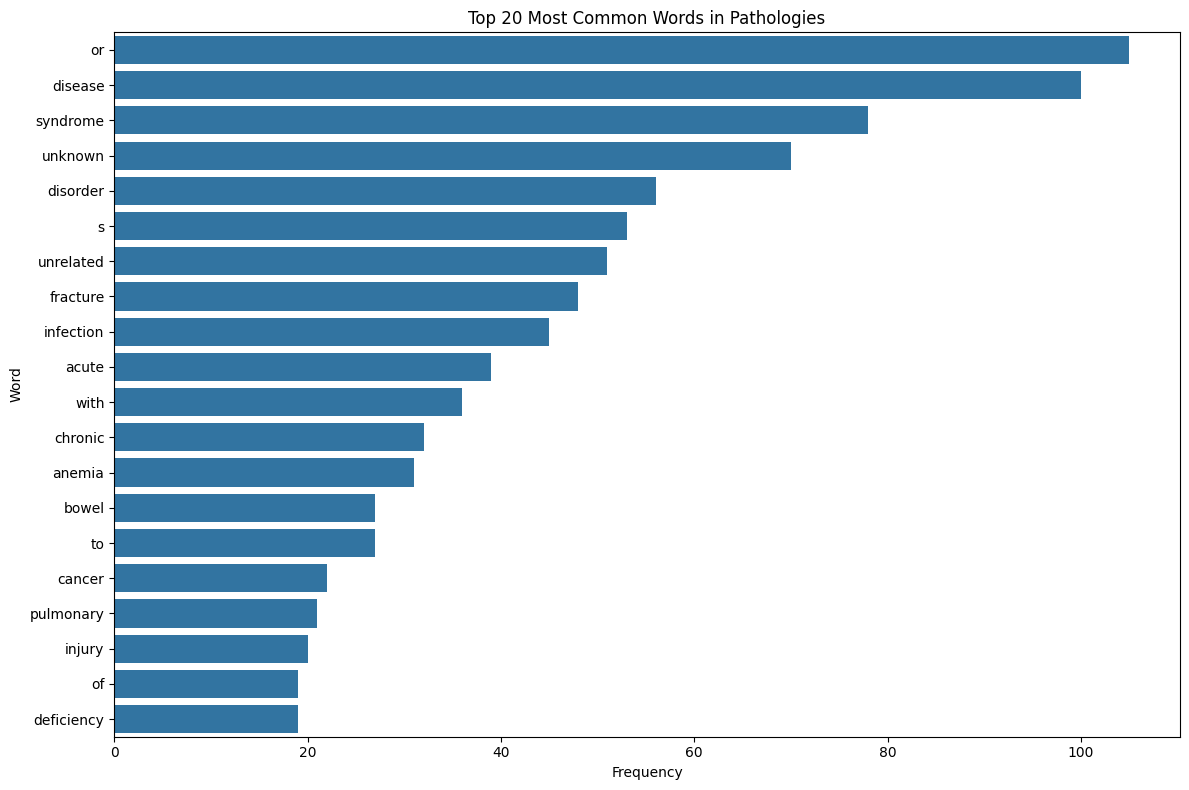

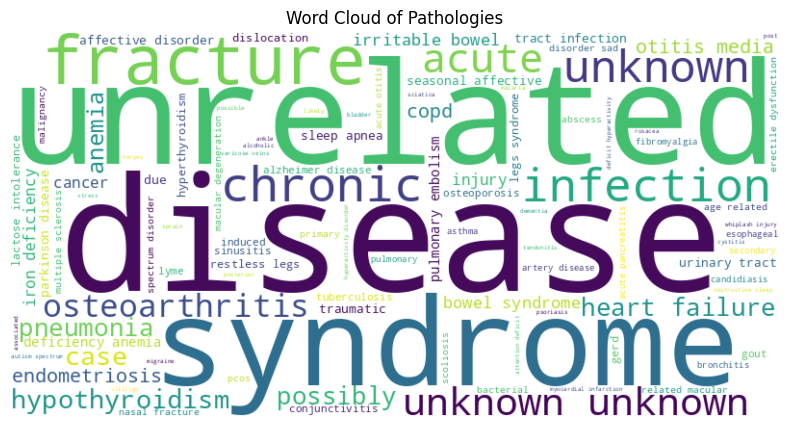

Pathology Complexity Analysis:
count    1412.000000
mean        2.755666
std         2.010727
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        21.000000
Name: Word_Count, dtype: float64




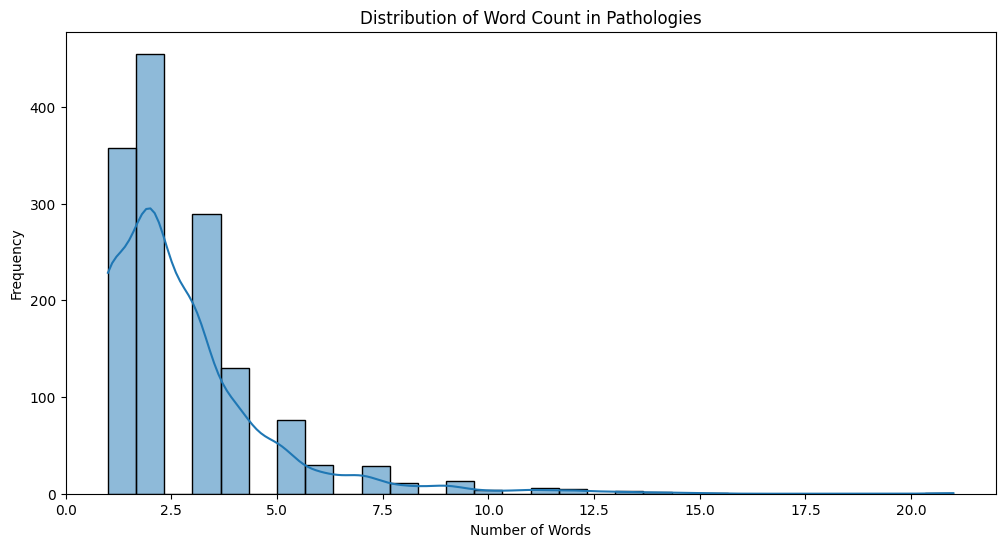

Number of missing values: 0


Potential Data Quality Issues:
Normalized_Pathology
unknown    69
Name: count, dtype: int64


59      gout
141     copd
159      bph
225     gout
265     gout
332      hiv
391     gout
414     gerd
569     adhd
630     gerd
710      bph
714     adhd
730     pcos
777     pcos
833     gout
869     gerd
882     copd
1007     ibd
1009    copd
1010    gerd
1018    gerd
1117    gout
1150    pcos
1163    gerd
1336    pcos
1377    copd
Name: Normalized_Pathology, dtype: object


10                                             trisomy 18
80            rett syndrome or mecp2 duplication syndrome
158              multiple endocrine neoplasia type 1 men1
196                                       type 1 diabetes
420                                       type 1 diabetes
501                                       type 1 diabetes
578     macrocytic anemia, possibly due to vitamin b12...
758                            case 2: gallbladder cancer
759                    case 3:

In [18]:
# Perform EDA on the Extracted_Pathology column

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Display basic information about the column
print("Basic Information:")
print(df['Normalized_Pathology'].info())
print("\n")

# Display summary statistics
print("Summary Statistics:")
print(df['Normalized_Pathology'].describe())
print("\n")

# Count unique values
unique_count = df['Normalized_Pathology'].nunique()
print(f"Number of unique pathologies: {unique_count}")
print("\n")

# Display top 15 most common pathologies
print("Top 15 Most Common Pathologies:")
top_pathologies = df['Normalized_Pathology'].value_counts().head(15)
print(top_pathologies)
print("\n")

# Visualize top 15 pathologies
plt.figure(figsize=(12, 8))
sns.barplot(x=top_pathologies.values, y=top_pathologies.index)
plt.title('Top 15 Most Common Pathologies')
plt.xlabel('Count')
plt.ylabel('Pathology')
plt.tight_layout()
plt.show()

# Calculate and display the average length of pathology descriptions
avg_length = df['Normalized_Pathology'].str.len().mean()
median_length = df['Normalized_Pathology'].str.len().median()
print(f"Average length of pathology descriptions: {avg_length:.2f} characters")
print(f"Median length of pathology descriptions: {median_length:.0f} characters")
print("\n")

# Display a histogram of pathology description lengths
plt.figure(figsize=(12, 6))
sns.histplot(df['Normalized_Pathology'].str.len(), bins=50, kde=True)
plt.title('Distribution of Pathology Description Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Analyze word frequency
def get_words(text):
    return re.findall(r'\w+', text.lower())

all_words = [word for pathology in df['Normalized_Pathology'] for word in get_words(pathology)]
word_freq = Counter(all_words)

# Display top 20 most common words
print("Top 20 Most Common Words:")
print(pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency']))
print("\n")

# Visualize top 20 words
plt.figure(figsize=(12, 8))
top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=top_words)
plt.title('Top 20 Most Common Words in Pathologies')
plt.tight_layout()
plt.show()

# Word cloud of pathologies (if wordcloud is installed)
try:
    from wordcloud import WordCloud
    
    text = ' '.join(df['Normalized_Pathology'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Pathologies')
    plt.show()
except ImportError:
    print("WordCloud not installed. Skipping word cloud visualization.")

# Analyze pathology complexity
df['Word_Count'] = df['Normalized_Pathology'].apply(lambda x: len(get_words(x)))

print("Pathology Complexity Analysis:")
print(df['Word_Count'].describe())
print("\n")

plt.figure(figsize=(12, 6))
sns.histplot(df['Word_Count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Pathologies')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Check for missing or null values
missing_values = df['Normalized_Pathology'].isnull().sum()
print(f"Number of missing values: {missing_values}")
print("\n")

# Check for potential data quality issues
print("Potential Data Quality Issues:")
print(df['Normalized_Pathology'].value_counts().head(1))  # Check if there's an overrepresented category
print("\n")
print(df['Normalized_Pathology'][df['Normalized_Pathology'].str.len() < 5])  # Check for very short descriptions
print("\n")
print(df['Normalized_Pathology'][df['Normalized_Pathology'].str.contains(r'\d')])  # Check for entries containing numbers

# Correlation with other columns (if applicable)
# Assuming there's a 'Severity' column, for example
# if 'Severity' in df.columns:
#     correlation = df['Normalized_Pathology'].astype('category').cat.codes.corr(df['Severity'])
#     print(f"Correlation between Extracted_Pathology and Severity: {correlation}")

In [ ]:
# Functions
def load_note(): # TODO: link to the doctor's actual input
    # return a string with the doctor note
    return "This patient's history of recurrent kidney stones, osteopenia, and high-dose vitamin D supplementation, along with laboratory findings of hypercalcemia and hypercalciuria, suggest the possibility of vitamin D toxicity. Excessive intake of vitamin D can cause increased absorption of calcium from the gut, leading to hypercalcemia and hypercalciuria, which can result in kidney stones and bone loss. Treatment would involve stopping the vitamin D supplementation and potentially providing intravenous fluids and loop diuretics to promote the excretion of calcium."

def extract_pathologies(completions, batch_size=1):
    results = []
    total = len(completions)
    for i in range(0, total, batch_size):
        batch = completions[i:i+batch_size]        
        prompt = "Given the following medical case descriptions, extract and return only the main pathology or condition mentioned for each case (one per line, one per case, in order). If the pathology is very unclear, return 'unknown', if the text is unrelated to a pathology description, then return 'unrelated'. DON'T RETURN ANYTHING ELSE BUT THE PATHOLOGIES:\n\n"
        for j, completion in enumerate(batch, 1):
            prompt += f"CASE {j}:\n{completion}\n\n"
        prompt += """
        EXAMPLE INPUT:
        CASE 1: This patient's history of recurrent kidney stones, osteopenia, and high-dose vitamin D supplementation, along with laboratory findings of hypercalcemia and hypercalciuria, suggest the possibility of vitamin D toxicity. Excessive intake of vitamin D can cause increased absorption of calcium from the gut, leading to hypercalcemia and hypercalciuria, which can result in kidney stones and bone loss. Treatment would involve stopping the vitamin D supplementation and potentially providing intravenous fluids and loop diuretics to promote the excretion of calcium.
        CASE 2: A 45-year-old patient presents with vague symptoms including fatigue, mild joint pain, and occasional headaches. Physical examination reveals no significant findings, and initial laboratory tests are within normal ranges. The patient's medical history is unremarkable, and they report no recent travel or exposure to infectious diseases. Despite thorough questioning, no clear pattern or specific triggers for the symptoms can be identified.
        CASE 2: This child's symptoms of a red, bulging tympanic membrane with systemic symptoms such as fever and headache, and the additional symptoms of dizziness and a spinning sensation, raise concern for complications of acute otitis media. The differential diagnosis could include labyrinthitis or possibly even mastoiditis. Urgent evaluation, including further imaging studies such as a CT or MRI scan, may be necessary. This child likely requires admission for intravenous antibiotics and possibly surgical intervention if mastoiditis is confirmed.
        CASE 4: While the symptoms might initially suggest asthma, the lack of response to bronchodilators indicates a different cause. A possible diagnosis in this case might be idiopathic pulmonary fibrosis, a type of lung disease that results in scarring (fibrosis) of the lungs for an unknown reason. High-resolution CT of the chest would be the next step in diagnosis.
        CASE 5: The annual report for XYZ Corporation shows a 15% increase in revenue compared to the previous fiscal year. The company attributes this growth to the successful launch of a new product line and expansion into international markets. The board of directors has approved a 5% dividend increase for shareholders. The report also outlines plans for sustainable practices and corporate social responsibility initiatives for the coming year.

        EXAMPLE OUTPUT:
        vitamin d toxicity
        unknown
        acute otitis media, possible complication of labyrinthitis or mastoiditis
        idiopathic pulmonary fibrosis
        unrelated
        """
        

        client = Groq(api_key="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")
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            model="llama-3.1-70b-versatile",
        )
        
        batch_results = response.choices[0].message.content.strip().split('\n')
        results.extend(batch_results)
    
    return results


In [1]:
class Patient:
    def __init__(self, id, active_pathologies=[]):
        self.id = id
        self.active_pathologies = active_pathologies


    def add_pathologies(self, pathologies):
        """Adds new pathologies to the patient's active pathologies and returns the new complete set

        Args:
            pathologies (_type_): _description_

        Returns:
            _type_: _description_
        """
        self.active_pathologies.extend(pathologies)
        return self.active_pathologies
        
    def remove_pathology(self, pathology):
        self.active_pathologies.remove(pathology)

In [ ]:
patient = Patient(1)

# Main flow
doctor_note = load_note()

# Extract pathology from doctor note
pathologies = extract_pathologies(doctor_note)

# If new pathologies are found, add it to the active pathologies of the patient
if new_pathologies := patient.has_new_pathologies(pathologies):
    # Add new pathology to the patient's active pathologies
    pathologies = patient.active_pathologies.add_pathologies(new_pathologies)
    
# Extract features that are trackable, and relate them to the active pathologies
# features = extract_features(doctor_note)

# TODO: Modify pathologies + features to be saved (human in the loop)

# Save features and pathologies to DB
# save_treatment_data(patient, features, pathologies)